# ChromaDB: Demonstração de Busca Semântica

## PARTE 1: Busca Semântica em Documentos de Texto

Este notebook demonstra de forma didática as capacidades do **ChromaDB** para realizar busca semântica em documentos de texto em português.

### Objetivos desta demonstração:

1. **Processar documentos** - Dividir textos em chunks (parágrafos)
2. **Gerar embeddings** - Transformar texto em vetores numéricos
3. **Armazenar no ChromaDB** - Persistir embeddings e metadados
4. **Busca semântica** - Encontrar documentos semanticamente similares

### Recursos:

- [ChromaDB Documentation](https://docs.trychroma.com/)
- [Sentence Transformers](https://www.sbert.net/)


## 1. Instalação e Configuração

Instalar as dependências necessárias para o Google Colab.

In [ ]:
# Instalação de dependências
!pip install -q chromadb sentence-transformers numpy pandas matplotlib seaborn plotly scikit-learn

In [36]:
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import re
from pathlib import Path
from typing import List, Dict, Tuple
import warnings

warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Corpus Sintético em Português

Criamos um conjunto de documentos de texto em português.

In [37]:
def create_sample_portuguese_texts():
    """
    Cria textos de exemplo em português..
    """
    texts = [
        {
            "id": "001",
            "title": "Tecnologia Brasileira em Ascensão",
            "content": "A tecnologia brasileira está em franco crescimento. Startups de São Paulo e outras cidades brasileiras têm desenvolvido soluções inovadoras em inteligência artificial, machine learning e cloud computing. O investimento em tecnologia no Brasil cresceu 45% no último ano.\n\nA formação de profissionais qualificados nas universidades tem impulsionado esse setor estratégico para a economia. Programas de aceleração e incubadoras apoiam empreendedores desde a concepção da ideia até a escalabilidade do negócio.",
            "category": "tecnologia"
        },
        {
            "id": "002",
            "title": "Agricultura Sustentável no Brasil",
            "content": "O agronegócio brasileiro está adotando práticas mais sustentáveis. Agricultores utilizam técnicas de agricultura de precisão, com drones e sensores IoT para monitorar plantações. O Brasil é líder mundial na produção de alimentos orgânicos certificados.\n\nA tecnologia blockchain começa a ser usada para rastreabilidade de produtos agrícolas. Sistemas de irrigação inteligente economizam água e energia, respondendo a condições climáticas em tempo real.",
            "category": "agronegocio"
        },
        {
            "id": "003",
            "title": "Educação Digital Transforma Ensino",
            "content": "A educação digital revoluciona o ensino no Brasil. Plataformas online democratizam o acesso ao conhecimento em regiões remotas. Professores utilizam ferramentas de gamificação para engajar alunos.\n\nA pandemia acelerou a adoção de metodologias ativas nas instituições de ensino. Ferramentas de videoconferência tornaram-se essenciais no ambiente educacional.""",
            "category": "educacao"
        },
        {
            "id": "004",
            "title": "Energia Renovável Avança no País",
            "content": "O Brasil amplia sua matriz de energia renovável. Parques eólicos no Nordeste geram eletricidade limpa para milhões de residências. Painéis solares se popularizam com financiamentos acessíveis.\n\nPesquisas desenvolvem tecnologias de hidrogênio verde. O país tem recursos naturais abundantes para liderar a transição energética global.",
            "category": "energia"
        },
        {
            "id": "005",
            "title": "Inteligência Artificial na Saúde",
            "content": "A inteligência artificial transforma a saúde brasileira. Algoritmos auxiliam médicos no diagnóstico precoce de doenças. Telemedicina conecta especialistas a pacientes em áreas remotas.\n\nPesquisadores desenvolvem modelos de IA adaptados para doenças tropicais. Sistemas de predição identificam surtos epidemiológicos precocemente.",
            "category": "saude"
        },
        {
            "id": "006",
            "title": "Fintechs Democratizam Serviços",
            "content": "Fintechs brasileiras lideram inovação na América Latina. Aplicativos de pagamento digital atendem milhões sem conta bancária tradicional. PIX revolucionou pagamentos instantâneos.\n\nOpen banking permite integração entre instituições. A regulação do Banco Central impulsiona competição e beneficia consumidores.",
            "category": "financas"
        },
        {
            "id": "007",
            "title": "Mobilidade Urbana Inteligente",
            "content": "Tecnologia revoluciona a mobilidade urbana. Aplicativos de transporte compartilhado reduzem uso de veículos particulares. Sistemas inteligentes otimizam fluxo de trânsito.\n\nPlataformas digitais integram diferentes modais de transporte. Análise de dados em tempo real melhora planejamento de rotas.",
            "category": "mobilidade"
        },
        {
            "id": "008",
            "title": "E-commerce em Expansão",
            "content": "O comércio eletrônico brasileiro cresce exponencialmente. Pequenos comerciantes vendem em marketplaces nacionais. Inteligência artificial personaliza recomendações de produtos.\n\nLogística avançada garante entregas rápidas. Live commerce une entretenimento e vendas online.",
            "category": "comercio"
        },
        {
            "id": "009",
            "title": "Cibersegurança em Foco",
            "content": "Cibersegurança torna-se prioridade empresarial. Ataques cibernéticos aumentam em sofisticação. Empresas investem em firewalls e autenticação multifator.\n\nLei Geral de Proteção de Dados impõe regras rigorosas. Startups desenvolvem tecnologias nacionais de segurança digital.",
            "category": "seguranca"
        },
        {
            "id": "010",
            "title": "Cloud Computing Transforma Negócios",
            "content": "Computação em nuvem revoluciona negócios. Empresas migram infraestrutura reduzindo custos. SaaS democratiza acesso a softwares empresariais.\n\nProvedores globais instalam datacenters no Brasil. Multi-cloud oferece flexibilidade e resiliência.",
            "category": "cloud"
        }
    ]
    return texts

# Carregar documentos
documents = create_sample_portuguese_texts()

print(f"Total de documentos: {len(documents)}")

Total de documentos: 10


## 3. Processamento e Chunking de Documentos

**Chunking** é o processo de dividir documentos grandes em pedaços menores. Vamos dividir cada documento por **parágrafos**.

### Por que fazer chunking?

- **Precisão**: Chunks menores melhoram a precisão da busca semântica
- **Performance**: Vetores menores são mais eficientes para comparação
- **Contexto**: Cada parágrafo mantém contexto semântico coerente

### Estratégia:
Vamos dividir cada documento pelos caracteres `\n\n` (quebra de linha dupla), que separam parágrafos.

In [ ]:
def chunk_documents(documents: List[Dict]) -> List[Dict]:
    """
    Divide documentos em chunks (parágrafos).
    
    Args:
        documents: Lista de documentos originais
        
    Returns:
        Lista de chunks com metadados preservados
    """
    chunks = []
    
    for doc in documents:
        # Divide o conteúdo por parágrafos (quebra dupla de linha)
        paragraphs = [p.strip() for p in doc['content'].split('\n\n') if p.strip()]
        
        # Cria um chunk para cada parágrafo
        for idx, paragraph in enumerate(paragraphs):
            chunk = {
                'chunk_id': f"{doc['id']}_p{idx+1}",  # ID único do chunk
                'doc_id': doc['id'],                   # ID do documento original
                'title': doc['title'],
                'category': doc['category'],
                'paragraph_num': idx + 1,
                'total_paragraphs': len(paragraphs),
                'content': paragraph,
                'char_count': len(paragraph)
            }
            chunks.append(chunk)
    
    return chunks

# Processar documentos
chunks = chunk_documents(documents)

In [ ]:
# Processar documentos
chunks = chunk_documents(documents)

print(f"Chunking concluído.")
print(f"Estatísticas:")
print(f"\t- Documentos originais: {len(documents)}")
print(f"\t- Total de chunks: {len(chunks)}")
print(f"\t- Média de chunks por documento: {len(chunks)/len(documents):.1f}")

# Mostrar exemplo de documento ANTES do chunking
print("\n\nANTES DO CHUNKING - Documento Original:\n")
print(f"ID: {documents[0]['id']}")
print(f"Título: {documents[0]['title']}")
print(f"Conteúdo completo:\n{documents[0]['content']}")

# Mostrar os chunks gerados deste documento
print("\n\nDEPOIS DO CHUNKING - Chunks Gerados:")
doc_chunks = [c for c in chunks if c['doc_id'] == '001']
for chunk in doc_chunks:
    print(f"\n\t- Chunk ID: {chunk['chunk_id']}")
    print(f"\t- Parágrafo: {chunk['paragraph_num']}/{chunk['total_paragraphs']}")
    print(f"\t- Tamanho: {chunk['char_count']} caracteres")
    print(f"\t- Conteúdo: {chunk['content'][:100]}...")
    print("-" * 100)

## 4. Geração de Embeddings

Vamos transformar texto em **vetores numéricos** (embeddings) usando o modelo **Sentence-BERT**.

### O que são Embeddings?

Embeddings são representações numéricas de texto que capturam o **significado semântico**:
- Textos similares têm vetores próximos no espaço vetorial
- Cada dimensão captura diferentes aspectos do significado
- Permitem comparação matemática entre textos

### Modelo Utilizado:
[**`paraphrase-multilingual-MiniLM-L12-v2`**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)
- Otimizado para português e outras línguas
- Gera vetores de **384 dimensões**
- Treinado em milhões de pares de sentenças

In [ ]:
# Carregar modelo de embeddings
embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
# Informações sobre o modelo
print(f"Informações do Modelo:")
print(f"\t- Dimensões do vetor: {embedding_model.get_sentence_embedding_dimension()}")

### Demonstração: Texto para Vetor

Vamos ver **passo a passo** como um chunk de texto é transformado em vetor.

In [ ]:
# Selecionar um chunk de exemplo
example_chunk = chunks[0]

In [ ]:
print("ANTES: TEXTO ORIGINAL\n")
print(f"\t- Chunk ID: {example_chunk['chunk_id']}")
print(f"\t- Categoria: {example_chunk['category']}")
print(f"\t- Tipo de dado: {type(example_chunk['content'])}")
print(f"\nConteúdo:")
print(f'"{example_chunk["content"]}"')

In [ ]:
# Gerar embedding
embedding = embedding_model.encode(example_chunk['content'])

In [ ]:
print("DEPOIS: VETOR DE EMBEDDING")
print(f"\t- Tipo de dado: {type(embedding)}")
print(f"\t- Dimensões: {embedding.shape}")
print(f"\nPrimeiros 10 valores do vetor:")
print(embedding[:10])
print(f"\nÚltimos 10 valores do vetor:")
print(embedding[-10:])

In [ ]:
# Visualizar distribuição dos valores
plt.figure(figsize=(12, 4))
plt.hist(embedding, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribuição dos Valores no Vetor de Embedding', fontsize=14, fontweight='bold')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretação:
- Cada número representa uma `feature` semântica abstraída do texto
- Textos similares terão vetores com valores próximos
- A distância entre vetores mede similaridade semântica

### Gerando Embeddings para Todos os Chunks

Agora vamos processar todos os chunks e gerar seus embeddings.

In [ ]:
# Gerar embeddings para todos os chunks
print("Gerando embeddings para todos os chunks...")
texts_to_encode = [chunk['content'] for chunk in chunks]
all_embeddings = embedding_model.encode(texts_to_encode, show_progress_bar=True)

In [ ]:
print(f"Shape da matriz de embeddings: {all_embeddings.shape}")
print(f"\t- {all_embeddings.shape[0]} chunks")
print(f"\t- {all_embeddings.shape[1]} dimensões por vetor")

In [ ]:
# Adicionar embeddings aos chunks
for chunk, embedding in zip(chunks, all_embeddings):
    chunk['embedding'] = embedding.tolist()

## 5. Inicializar ChromaDB e Criar Coleção

Vamos configurar o **ChromaDB** para armazenar nossos embeddings.

### O que é ChromaDB?

ChromaDB é um banco de dados vetorial que:
- Armazena embeddings eficientemente
- Realiza buscas de similaridade rápidas
- Mantém metadados associados aos vetores

In [ ]:
# Criar cliente ChromaDB (em memória para demonstração)
chroma_client = chromadb.Client()

# Criar coleção
collection_name = "documentos_portugues"

# Deletar coleção se já existir (para re-executar o notebook)
try:
    chroma_client.delete_collection(collection_name)
except:
    pass

collection = chroma_client.create_collection(
    name=collection_name,
    metadata={"description": "Documentos em português", "hnsw:space": "cosine"}
)

print(f"ChromaDB inicializado.")
print(f"Coleção criada: '{collection_name}'")
print(f"\nConfigurações da coleção:")
print(f"\t- Nome: {collection.name}")
print(f"\t- Metadados: {collection.metadata}")
print(f"\t- Métrica de distância: Cosine")
print(f"\t- Quantidade de documentos: {collection.count()}")

### Inserindo Chunks no ChromaDB

Vamos adicionar todos os chunks com seus embeddings e metadados.

In [ ]:
# Preparar dados para inserção
ids = [chunk['chunk_id'] for chunk in chunks]
embeddings_list = [chunk['embedding'] for chunk in chunks]
documents_list = [chunk['content'] for chunk in chunks]
metadatas = [
    {
        'doc_id': chunk['doc_id'],
        'title': chunk['title'],
        'category': chunk['category'],
        'paragraph_num': chunk['paragraph_num'],
        'char_count': chunk['char_count']
    }
    for chunk in chunks
]

print("Inserindo chunks no ChromaDB...")
collection.add(
    ids=ids,
    embeddings=embeddings_list,
    documents=documents_list,
    metadatas=metadatas
)

print(f"Chunks inseridos com sucesso.")
print(f"\nEstatísticas da coleção:")
print(f"\t- Total de documentos: {collection.count()}")
print(f"\t- IDs de exemplo: {ids[:3]}")
print(f"\nO que foi armazenado:")
print(f"\t- Embeddings vetoriais ({all_embeddings.shape[1]} dimensões)")
print(f"\t- Textos originais dos chunks")
print(f"\t- Metadados (categoria, título, etc)")
print(f"\t- IDs únicos para cada chunk")

## 6. Busca Semântica

Agora vamos realizar uma **busca semântica** e entender cada etapa do processo!

### Como funciona a busca semântica?

1. **Query:** Convertida em embedding
2. **Comparação:** Calcula similaridade com todos os vetores armazenados
3. **Ranking:** Ordena resultados por similaridade
4. **Retorno:** Devolve os k documentos mais similares

In [ ]:
# Definir query de busca
query_text = "inteligência artificial e machine learning em hospitais"

print("ETAPA 1: QUERY ORIGINAL")
print(f'Query: "{query_text}"')
print(f"Tipo: {type(query_text)}")
print(f"Tamanho: {len(query_text)} caracteres")

In [ ]:
# Converter query em embedding
query_embedding = embedding_model.encode(query_text)

print("ETAPA 2: QUERY COMO VETOR")
print(f"Dimensões: {query_embedding.shape}")
print(f"Primeiros 10 valores: {query_embedding[:10]}")
print(f"\nAgora a query está no mesmo 'espaço vetorial' que os documentos.")

In [ ]:
# Realizar busca no ChromaDB
results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=3  # Top 3 resultados mais similares
)

print("ETAPA 3: RESULTADOS DA BUSCA")
print(f"Encontrados: {len(results['ids'][0])} resultados")

In [ ]:
# Mostrar resultados detalhados
for idx, (doc_id, document, metadata, distance) in enumerate(zip(
    results['ids'][0],
    results['documents'][0],
    results['metadatas'][0],
    results['distances'][0]
), 1):
    similarity_score = (1 - (distance / 2)) * 100  # Converter para porcentagem 0-100%
    print(f"\nResultado #{idx}")
    print(f"\t- Chunk ID: {doc_id}")
    print(f"\t- Título: {metadata['title']}")
    print(f"\t- Categoria: {metadata['category']}")
    print(f"\t- Distância Cosine: {distance:.4f} (menor = melhor)")
    print(f"\t- Match Score: {similarity_score:.1f}%")
    print(f"\t- Conteúdo: {document[:100]}...")
    print("-" * 100)

### Visualizando Similaridade entre Query e Resultados

Vamos calcular e visualizar as similaridades usando **cosseno**.

In [ ]:
# Pegar embeddings dos resultados
result_chunk_ids = results['ids'][0]
result_embeddings = []

for chunk_id in result_chunk_ids:
    chunk = next(c for c in chunks if c['chunk_id'] == chunk_id)
    result_embeddings.append(chunk['embedding'])

result_embeddings = np.array(result_embeddings)

# Calcular similaridade de cosseno
query_emb_2d = query_embedding.reshape(1, -1)
similarities = cosine_similarity(query_emb_2d, result_embeddings)[0]

# Criar visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras de similaridade
categories = [results['metadatas'][0][i]['category'] for i in range(len(similarities))]
colors = plt.cm.viridis(np.linspace(0, 1, len(similarities)))

bars = ax1.barh(range(len(similarities)), similarities, color=colors)
ax1.set_yticks(range(len(similarities)))
ax1.set_yticklabels([f"Resultado {i+1}\n({cat})" for i, cat in enumerate(categories)])
ax1.set_xlabel('Similaridade de Cosseno', fontweight='bold')
ax1.set_title('Similaridade: Query vs Resultados', fontweight='bold')
ax1.set_xlim(0, 1)

for i, (bar, sim) in enumerate(zip(bars, similarities)):
    ax1.text(sim + 0.01, i, f'{sim:.4f}', va='center')

# Heatmap de comparação
comparison_matrix = np.zeros((1, len(similarities)))
comparison_matrix[0] = similarities

im = ax2.imshow(comparison_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_yticks([0])
ax2.set_yticklabels(['Query'])
ax2.set_xticks(range(len(similarities)))
ax2.set_xticklabels([f'R{i+1}' for i in range(len(similarities))])
ax2.set_title('Mapa de Calor de Similaridade', fontweight='bold')

for i in range(len(similarities)):
    ax2.text(i, 0, f'{similarities[i]:.3f}', ha='center', va='center', fontweight='bold')

plt.colorbar(im, ax=ax2, label='Similaridade')
plt.tight_layout()
plt.show()

print("Interpretação:")
print("\t- Valores próximos de 1.0 = Alta similaridade")
print("\t- Valores próximos de 0.0 = Baixa similaridade")
print(f"\t- Resultado mais similar: {similarities.max():.4f}")

## 7. Experimentos Adicionais - Diferentes Queries

Vamos testar a busca semântica com diferentes queries e ver como o sistema responde!

In [ ]:
# Diferentes queries para testar
test_queries = [
    "pagamentos digitais e bancos",
    "energia solar e sustentabilidade",
    "ensino online e educação",
    "segurança de dados e proteção"
]

print("TESTANDO MÚLTIPLAS QUERIES:")

results_summary = []

for query in test_queries:
    # Gerar embedding da query
    query_emb = embedding_model.encode(query)
    
    # Buscar no ChromaDB
    search_results = collection.query(
        query_embeddings=[query_emb.tolist()],
        n_results=1  # Top 1 resultado
    )
    
    # Armazenar resultados
    distance_val = search_results['distances'][0][0]
    similarity_score = (1 - (distance_val / 2)) * 100
    top_result = {
        'query': query,
        'doc_id': search_results['ids'][0][0],
        'title': search_results['metadatas'][0][0]['title'],
        'category': search_results['metadatas'][0][0]['category'],
        'distance': distance_val,
        'similarity_score': similarity_score,
        'content': search_results['documents'][0][0][:100]
    }
    results_summary.append(top_result)
    
    print(f"\nQuery: \"{query}\"")
    print(f"\t- Melhor match: {top_result['title']}")
    print(f"\t- Categoria: {top_result['category']}")
    print(f"\t- Match Score: {similarity_score:.1f}%")
    print(f"\t- Trecho: {top_result['content']}...")

In [ ]:
# Criar visualização comparativa
fig, ax = plt.subplots(figsize=(12, 6))

queries_short = [q[:30] + '...' if len(q) > 30 else q for q in test_queries]
similarity_scores = [r['similarity_score'] for r in results_summary]
categories = [r['category'] for r in results_summary]

bars = ax.barh(range(len(queries_short)), similarity_scores)

# Colorir por categoria
category_colors = {cat: plt.cm.Set3(i) for i, cat in enumerate(set(categories))}
for bar, cat in zip(bars, categories):
    bar.set_color(category_colors[cat])

ax.set_yticks(range(len(queries_short)))
ax.set_yticklabels(queries_short)
ax.set_xlabel('Match Score (%)', fontweight='bold')
ax.set_title('Match Score das Queries com Melhor Resultado', fontweight='bold')
ax.set_xlim(0, 100)

for i, (bar, score, cat) in enumerate(zip(bars, similarity_scores, categories)):
    ax.text(score + 2, i, f'{score:.1f}% ({cat})', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Análise de Metadados - Filtragem por Categoria

ChromaDB permite filtrar resultados por metadados. Vamos buscar documentos de uma categoria específica!

In [ ]:
# Busca com filtro de categoria
query_filtered = "tecnologia e inovação"
target_category = "saude"

print(f"Query: \"{query_filtered}\"")
print(f"Filtrando apenas categoria: {target_category}\n")

In [ ]:
# Busca SEM filtro
results_no_filter = collection.query(
    query_embeddings=[embedding_model.encode(query_filtered).tolist()],
    n_results=3
)

# Busca COM filtro
results_with_filter = collection.query(
    query_embeddings=[embedding_model.encode(query_filtered).tolist()],
    n_results=3,
    where={"category": target_category}  # Filtro por metadado
)

In [ ]:
print("RESULTADOS SEM FILTRO (Top 3 geral)")
for i in range(len(results_no_filter['ids'][0])):
    distance = results_no_filter['distances'][0][i]
    similarity_score = (1 - (distance / 2)) * 100
    print(f"{i+1}. {results_no_filter['metadatas'][0][i]['title']}")
    print(f"\t- Categoria: {results_no_filter['metadatas'][0][i]['category']}")
    print(f"\t- Match Score: {similarity_score:.1f}%\n")

print(f"\nRESULTADOS COM FILTRO (Top 3 em '{target_category}')")
for i in range(len(results_with_filter['ids'][0])):
    distance = results_with_filter['distances'][0][i]
    similarity_score = (1 - (distance / 2)) * 100
    print(f"{i+1}. {results_with_filter['metadatas'][0][i]['title']}")
    print(f"\t- Categoria: {results_with_filter['metadatas'][0][i]['category']}")
    print(f"\t- Match Score: {similarity_score:.1f}%\n")

print("Vantagem: Combina busca semântica com filtros estruturados.")

# PARTE 2: Busca Semântica em Imagens

## Demonstração com Modelo CLIP

Agora vamos explorar a busca semântica em **imagens** usando o modelo [**CLIP** (Contrastive Language-Image Pre-training)](https://huggingface.co/openai/clip-vit-base-patch32) da OpenAI.

### Objetivos desta parte:

1. **Download de imagens** - Food-101 dataset (alta resolução)
2. **Gerar embeddings com CLIP** - Transformar imagens em vetores
3. **Armazenar no ChromaDB** - Persistir embeddings de imagens
4. **Busca texto→imagem** - Encontrar imagens usando descrições
5. **Busca imagem→imagem** - Encontrar imagens similares

### Sobre o CLIP:

CLIP é um modelo **multimodal** que aprende representações visuais e textuais no **mesmo espaço vetorial**:
- Imagens e textos relacionados têm embeddings próximos
- Permite buscar imagens usando texto natural
- Pré-treinado em 400 milhões de pares imagem-texto da internet

## 1. Instalação de Dependências para Imagens

Instalar bibliotecas adicionais para processamento de imagens e CLIP.

In [ ]:
# Instalar dependências para processamento de imagens e CLIP
!pip install -q torch torchvision transformers datasets pillow requests

In [38]:
# Importar bibliotecas adicionais
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

print(f"PyTorch versão: {torch.__version__}")
print(f"CUDA disponível: {torch.cuda.is_available()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

PyTorch versão: 2.6.0+cu118
CUDA disponível: True
Usando dispositivo: cuda


## 2. Download de Imagens de Alimentos

Vamos usar imagens de alta qualidade de alimentos de **fontes abertas** (Unsplash).

### Características:
- **Resolução**: ~512x512 pixels (alta qualidade)
- **Categorias**: Pizza, Sushi, Burger, Salad, Pasta, Steak, Ice Cream, Cake, Coffee, Fruits
- **Total**: 50 imagens de demonstração (5 por categoria)
- **Formato**: RGB colorido

Para demonstração, vamos usar **50 imagens** com 5 de cada categoria.

In [39]:
# URLs de imagens de alimentos de alta qualidade - 5 imagens por categoria
image_urls_data = [
    # Pizza (5 imagens)
    ("https://images.unsplash.com/photo-1513104890138-7c749659a591?w=512&q=80", "pizza", "Pizza Margherita"),
    ("https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=512&q=80", "pizza", "Pepperoni Pizza"),
    ("https://images.unsplash.com/photo-1574071318508-1cdbab80d002?w=512&q=80", "pizza", "Vegetarian Pizza"),
    ("https://images.unsplash.com/photo-1593560708920-61dd98c46a4e?w=512&q=80", "pizza", "Neapolitan Pizza"),
    ("https://images.unsplash.com/photo-1628840042765-356cda07504e?w=512&q=80", "pizza", "Wood Fired Pizza"),
    
    # Sushi (5 imagens)
    ("https://images.unsplash.com/photo-1579584425555-c3ce17fd4351?w=512&q=80", "sushi", "Sushi Platter"),
    ("https://images.unsplash.com/photo-1617196034796-73dfa7b1fd56?w=512&q=80", "sushi", "Salmon Sushi"),
    ("https://images.unsplash.com/photo-1611143669185-af224c5e3252?w=512&q=80", "sushi", "Sushi Rolls"),
    ("https://images.unsplash.com/photo-1564489563601-c53cfc451e93?w=512&q=80", "sushi", "Nigiri Sushi"),
    ("https://images.unsplash.com/photo-1583623025817-d180a2221d0a?w=512&q=80", "sushi", "California Roll"),
    
    # Burger (5 imagens)
    ("https://images.unsplash.com/photo-1568901346375-23c9450c58cd?w=512&q=80", "burger", "Classic Burger"),
    ("https://images.unsplash.com/photo-1550547660-d9450f859349?w=512&q=80", "burger", "Cheeseburger"),
    ("https://images.unsplash.com/photo-1571091718767-18b5b1457add?w=512&q=80", "burger", "Bacon Burger"),
    ("https://images.unsplash.com/photo-1553979459-d2229ba7433b?w=512&q=80", "burger", "Double Burger"),
    ("https://images.unsplash.com/photo-1572802419224-296b0aeee0d9?w=512&q=80", "burger", "Gourmet Burger"),
    
    # Salad (5 imagens)
    ("https://images.unsplash.com/photo-1512621776951-a57141f2eefd?w=512&q=80", "salad", "Caesar Salad"),
    ("https://images.unsplash.com/photo-1540189549336-e6e99c3679fe?w=512&q=80", "salad", "Mixed Greens"),
    ("https://images.unsplash.com/photo-1546793665-c74683f339c1?w=512&q=80", "salad", "Greek Salad"),
    ("https://images.unsplash.com/photo-1505576399279-565b52d4ac71?w=512&q=80", "salad", "Fresh Garden Salad"),
    ("https://images.unsplash.com/photo-1607532941433-304659e8198a?w=512&q=80", "salad", "Quinoa Salad"),
    
    # Pasta (5 imagens)
    ("https://images.unsplash.com/photo-1621996346565-e3dbc646d9a9?w=512&q=80", "pasta", "Spaghetti"),
    ("https://images.unsplash.com/photo-1563379926898-05f4575a45d8?w=512&q=80", "pasta", "Penne Pasta"),
    ("https://images.unsplash.com/photo-1612874742237-6526221588e3?w=512&q=80", "pasta", "Carbonara"),
    ("https://images.unsplash.com/photo-1473093295043-cdd812d0e601?w=512&q=80", "pasta", "Pasta Bolognese"),
    ("https://images.unsplash.com/photo-1608219992759-8d74ed8d76eb?w=512&q=80", "pasta", "Fettuccine"),
    
    # Steak (5 imagens)
    ("https://images.unsplash.com/photo-1600891964092-4316c288032e?w=512&q=80", "steak", "Grilled Steak"),
    ("https://images.unsplash.com/photo-1546833999-b9f581a1996d?w=512&q=80", "steak", "Ribeye Steak"),
    ("https://images.unsplash.com/photo-1603360946369-dc9bb6258143?w=512&q=80", "steak", "T-Bone Steak"),
    ("https://images.unsplash.com/photo-1558030006-450675393462?w=512&q=80", "steak", "Sirloin Steak"),
    ("https://images.unsplash.com/photo-1588168333986-5078d3ae3976?w=512&q=80", "steak", "Beef Steak"),
    
    # Ice Cream (5 imagens)
    ("https://images.unsplash.com/photo-1563805042-7684c019e1cb?w=512&q=80", "ice_cream", "Vanilla Ice Cream"),
    ("https://images.unsplash.com/photo-1497034825429-c343d7c6a68f?w=512&q=80", "ice_cream", "Chocolate Ice Cream"),
    ("https://images.unsplash.com/photo-1571506165871-ee72a35bc9dd?w=512&q=80", "ice_cream", "Strawberry Ice Cream"),
    ("https://images.unsplash.com/photo-1567206563064-6f60f40a2b57?w=512&q=80", "ice_cream", "Mint Ice Cream"),
    ("https://images.unsplash.com/photo-1501443762994-82bd5dace89a?w=512&q=80", "ice_cream", "Gelato"),
    
    # Cake (5 imagens)
    ("https://images.unsplash.com/photo-1578985545062-69928b1d9587?w=512&q=80", "cake", "Chocolate Cake"),
    ("https://images.unsplash.com/photo-1464349095431-e9a21285b5f3?w=512&q=80", "cake", "Birthday Cake"),
    ("https://images.unsplash.com/photo-1606890737304-57a1ca8a5b62?w=512&q=80", "cake", "Cheesecake"),
    ("https://images.unsplash.com/photo-1565958011703-44f9829ba187?w=512&q=80", "cake", "Red Velvet Cake"),
    ("https://images.unsplash.com/photo-1586985289906-406988974504?w=512&q=80", "cake", "Carrot Cake"),
    
    # Coffee (5 imagens)
    ("https://images.unsplash.com/photo-1509042239860-f550ce710b93?w=512&q=80", "coffee", "Espresso"),
    ("https://images.unsplash.com/photo-1461023058943-07fcbe16d735?w=512&q=80", "coffee", "Cappuccino"),
    ("https://images.unsplash.com/photo-1517487881594-2787fef5ebf7?w=512&q=80", "coffee", "Latte"),
    ("https://images.unsplash.com/photo-1572442388796-11668a67e53d?w=512&q=80", "coffee", "Americano"),
    ("https://images.unsplash.com/photo-1514432324607-a09d9b4aefdd?w=512&q=80", "coffee", "Mocha"),
    
    # Fruits (5 imagens)
    ("https://images.unsplash.com/photo-1619566636858-adf3ef46400b?w=512&q=80", "fruits", "Mixed Fruits"),
    ("https://images.unsplash.com/photo-1490885578174-acda8905c2c6?w=512&q=80", "fruits", "Fresh Berries"),
    ("https://images.unsplash.com/photo-1528825871115-3581a5387919?w=512&q=80", "fruits", "Strawberries"),
    ("https://images.unsplash.com/photo-1587334207976-c52c0f6f45a4?w=512&q=80", "fruits", "Tropical Fruits"),
    ("https://images.unsplash.com/photo-1610832958506-aa56368176cf?w=512&q=80", "fruits", "Citrus Fruits"),
]

print(f"Baixando {len(image_urls_data)} imagens (5 por categoria)...")

# Preparar lista de imagens e metadados
images_data = []

for idx, (url, category, label_name) in enumerate(image_urls_data):
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        
        images_data.append({
            'id': f'food_{idx:03d}',
            'image': img,
            'label_id': category,  # Usar categoria como label_id
            'label_name': label_name,
            'category': category,  # Adicionar campo categoria
            'width': img.size[0],
            'height': img.size[1]
        })
        print(f"[{category:10s}] {label_name} ({img.size[0]}x{img.size[1]})")
    except Exception as e:
        print(f"Erro ao baixar {label_name}: {e}")

# Estatísticas por categoria
from collections import Counter
category_counts = Counter(img['category'] for img in images_data)

print(f"\n{len(images_data)} imagens carregadas com sucesso.")
print(f"Informações:")
print(f"\t- Total de imagens: {len(images_data)}")
print(f"\t- Categorias únicas: {len(category_counts)}")
print(f"\nDistribuição por categoria:")
for category, count in sorted(category_counts.items()):
    print(f"\t- {category:12s}: {count} imagens")

Baixando 50 imagens (5 por categoria)...
[pizza     ] Pizza Margherita (512x341)
[pizza     ] Pepperoni Pizza (512x619)
[pizza     ] Vegetarian Pizza (512x342)
[pizza     ] Neapolitan Pizza (512x683)
[pizza     ] Wood Fired Pizza (512x512)
[sushi     ] Sushi Platter (512x909)
[sushi     ] Salmon Sushi (512x341)
[sushi     ] Sushi Rolls (512x288)
[sushi     ] Nigiri Sushi (512x768)
[sushi     ] California Roll (512x341)
[burger    ] Classic Burger (512x425)
[burger    ] Cheeseburger (512x640)
[burger    ] Bacon Burger (512x341)
[burger    ] Double Burger (512x387)
[burger    ] Gourmet Burger (512x364)
[salad     ] Caesar Salad (512x341)
[salad     ] Mixed Greens (512x768)
[salad     ] Greek Salad (512x768)
[salad     ] Fresh Garden Salad (512x768)
[salad     ] Quinoa Salad (512x382)
[pasta     ] Spaghetti (512x512)
[pasta     ] Penne Pasta (512x341)
[pasta     ] Carbonara (512x341)
[pasta     ] Pasta Bolognese (512x342)
[pasta     ] Fettuccine (512x768)
[steak     ] Grilled Steak (512x3

In [40]:
print(f"Primeiras 5 imagens:")
for i in range(min(5, len(images_data))):
    img_info = images_data[i]
    print(f"{i+1}. {img_info['id']}: {img_info['label_name']} ({img_info['width']}x{img_info['height']})")

Primeiras 5 imagens:
1. food_000: Pizza Margherita (512x341)
2. food_001: Pepperoni Pizza (512x619)
3. food_002: Vegetarian Pizza (512x342)
4. food_003: Neapolitan Pizza (512x683)
5. food_004: Wood Fired Pizza (512x512)


### Visualização das Imagens Baixadas

Vamos visualizar uma amostra das imagens do dataset (primeiras 20).

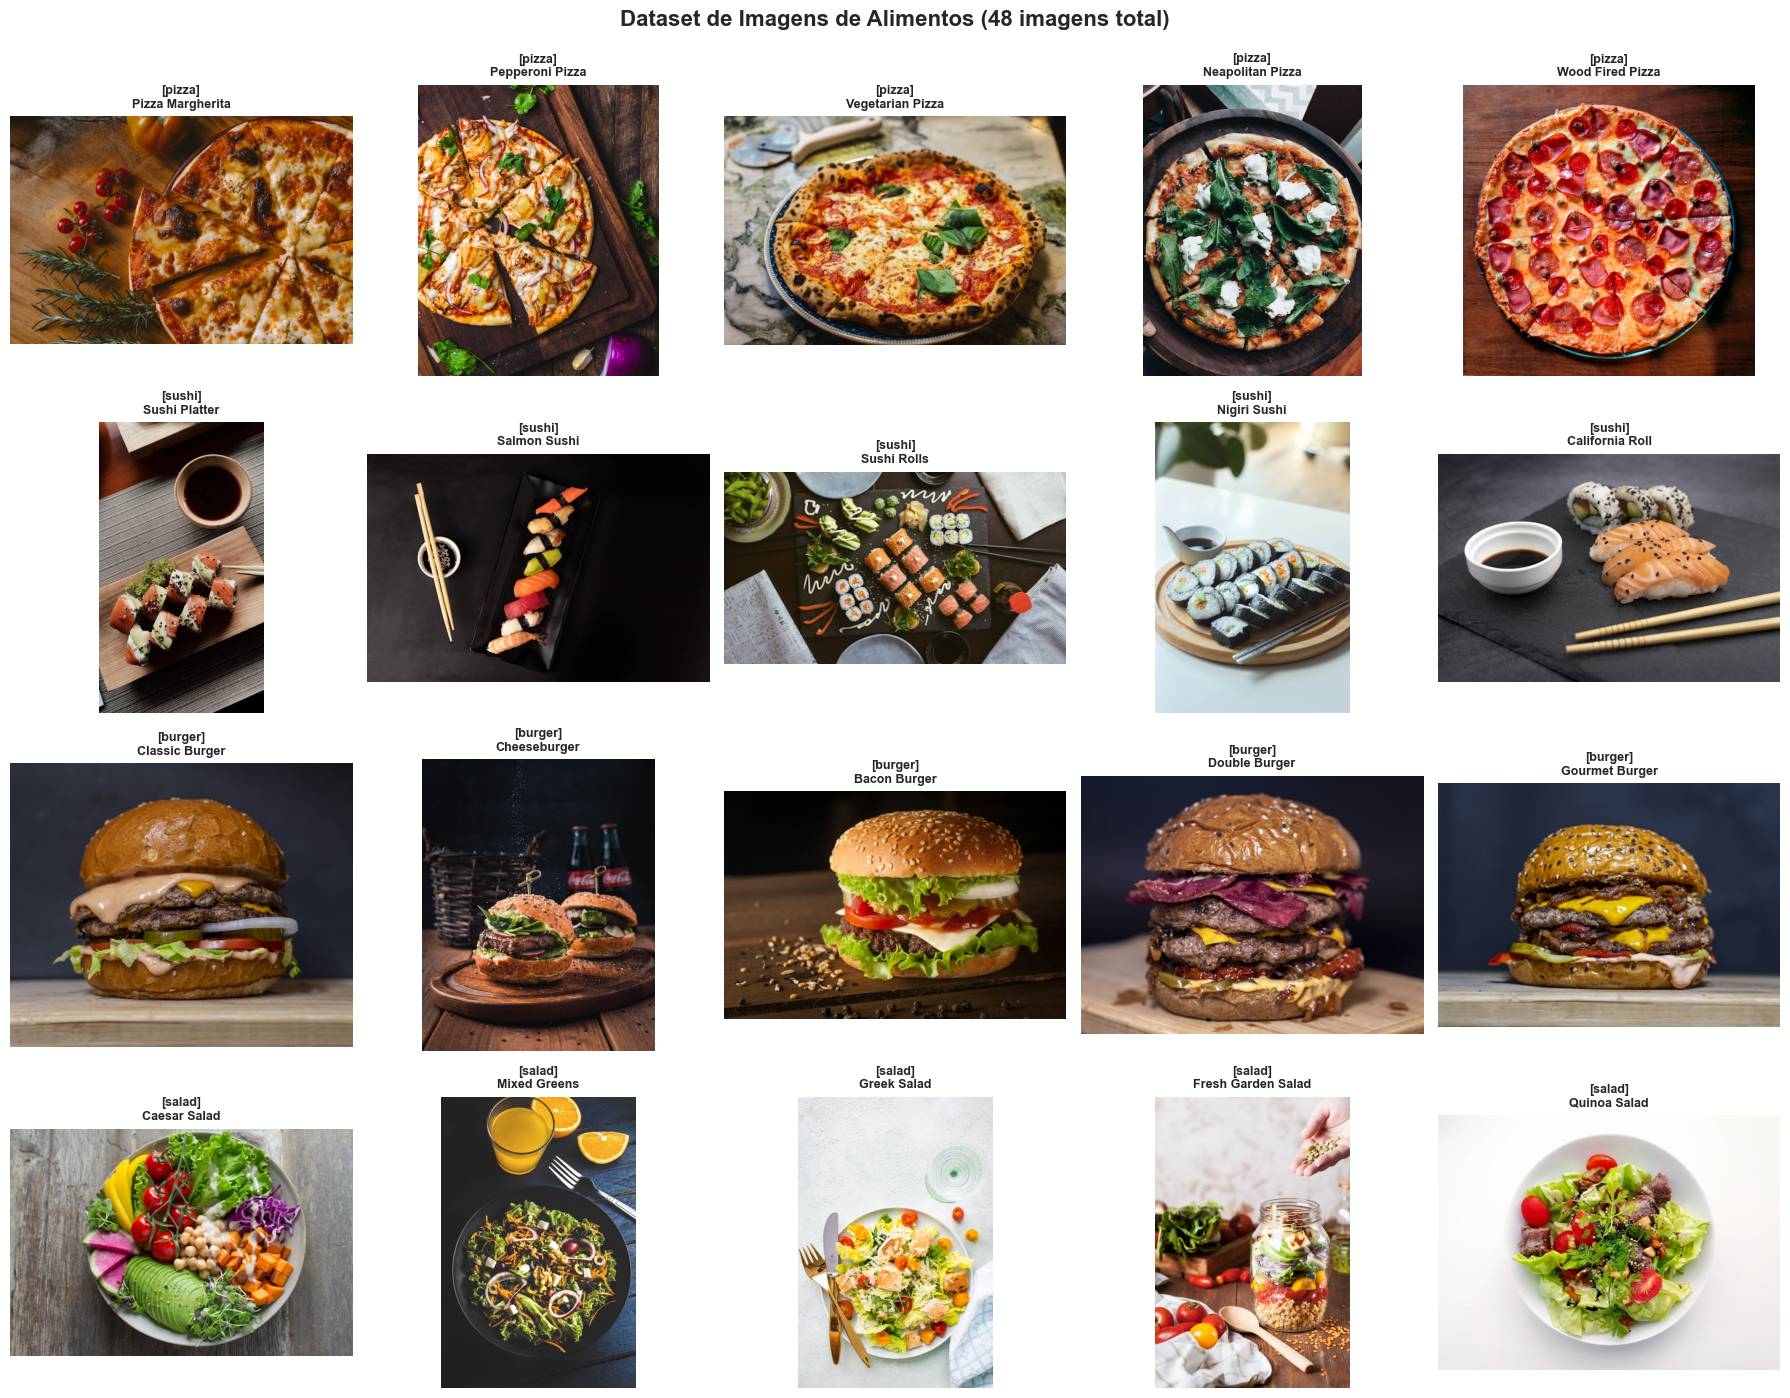

In [41]:
# Visualizar grid de imagens (4x5 = 20 primeiras imagens)
fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

for idx in range(min(20, len(images_data))):
    img_info = images_data[idx]
    axes[idx].imshow(img_info['image'])
    axes[idx].set_title(f"[{img_info['category']}]\n{img_info['label_name']}", 
                        fontsize=9, fontweight='bold')
    axes[idx].axis('off')

# Ocultar eixos extras se houver menos de 20 imagens
for idx in range(min(20, len(images_data)), 20):
    axes[idx].axis('off')

plt.suptitle(f'Dataset de Imagens de Alimentos ({len(images_data)} imagens total)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 3. Carregar Modelo CLIP

Vamos carregar o modelo **CLIP** da OpenAI para gerar embeddings multimodais.

### Arquitetura do CLIP:

![CLIP Architecture](https://i.ytimg.com/vi/X-rNSi7A5gA/maxresdefault.jpg)


### Características:
- **Modelo**: `openai/clip-vit-base-patch32`
- **Dimensões**: 512 (tanto para imagem quanto texto)
- **Espaço compartilhado**: Imagens e textos no mesmo espaço vetorial

In [44]:
# Carregar modelo CLIP
model_name = "openai/clip-vit-base-patch32"

clip_model = CLIPModel.from_pretrained(model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)

# Modo de avaliação (sem treinar)
clip_model.eval()
print(f"Modelo CLIP carregado: {model_name}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Modelo CLIP carregado: openai/clip-vit-base-patch32


## 4. Transformação: Imagem → Vetor

Vamos demonstrar como uma imagem é transformada em vetor pelo CLIP.

### Processo de Transformação:

1. **Input**: Imagem RGB (altura × largura × 3 canais)
2. **Pré-processamento**: Redimensionar para 224×224, normalizar
3. **Vision Transformer**: Dividir em patches de 32×32
4. **Encoding**: Processar patches através de camadas de atenção
5. **Output**: Vetor de 512 dimensões normalizado

In [47]:
# Selecionar uma imagem de exemplo
example_img_data = images_data[0]
example_image = example_img_data['image']

# Converter para array numpy para análise
img_array = np.array(example_image)

print("ANTES: IMAGEM ORIGINAL")
print(f"\t- ID: {example_img_data['id']}")
print(f"\t- Categoria: {example_img_data['label_name']}")
print(f"\t- Tipo de dado: {type(example_image)}")
print(f"\t- Dimensões: {example_image.size[0]}×{example_image.size[1]} pixels")
print(f"\t- Modo: {example_image.mode} (RGB - 3 canais de cor)")
print(f"\t- Shape do array: {img_array.shape} (altura x largura x canais)")
print(f"\t- Tipo de dado: {img_array.dtype}")

ANTES: IMAGEM ORIGINAL
	- ID: food_000
	- Categoria: Pizza Margherita
	- Tipo de dado: <class 'PIL.Image.Image'>
	- Dimensões: 512×341 pixels
	- Modo: RGB (RGB - 3 canais de cor)
	- Shape do array: (341, 512, 3) (altura x largura x canais)
	- Tipo de dado: uint8


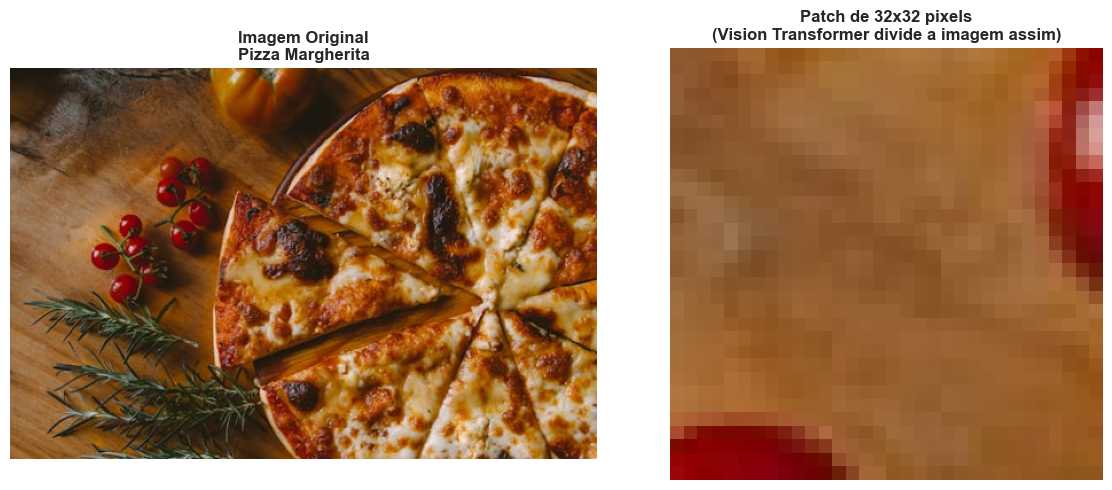

In [52]:
# Mostrar imagem
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Imagem original
axes[0].imshow(example_image)
axes[0].set_title(f'Imagem Original\n{example_img_data["label_name"]}', 
                  fontweight='bold', fontsize=12)
axes[0].axis('off')

# Visualizar alguns pixels
sample_region = img_array[100:132, 100:132]  # 32x32 patch
axes[1].imshow(sample_region)
axes[1].set_title('Patch de 32x32 pixels\n(Vision Transformer divide a imagem assim)', 
                  fontweight='bold', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [49]:
# Pré-processar imagem
inputs = clip_processor(images=example_image, return_tensors="pt").to(device)

# Gerar embedding
with torch.no_grad():
    image_features = clip_model.get_image_features(**inputs)
    # Normalizar (importante para similaridade de cosseno)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

# Converter para numpy
image_embedding = image_features.cpu().numpy().flatten()

In [50]:
print("DEPOIS: VETOR DE EMBEDDING")
print(f"\t- Tipo de dado: {type(image_embedding)}")
print(f"\t- Dimensões: {image_embedding.shape}")
print(f"\t- Total de números: {len(image_embedding)}")
print(f"\nPrimeiros 10 valores:")
print(image_embedding[:10])
print(f"\nÚltimos 10 valores:")
print(image_embedding[-10:])

DEPOIS: VETOR DE EMBEDDING
	- Tipo de dado: <class 'numpy.ndarray'>
	- Dimensões: (512,)
	- Total de números: 512

Primeiros 10 valores:
[ 0.02148304  0.01867752 -0.00013691  0.02005955  0.0444736   0.02311897
  0.00956361  0.05578773  0.00592319 -0.02071315]

Últimos 10 valores:
[-0.02884135 -0.00640183 -0.01952347 -0.05936848  0.01827305 -0.00215731
  0.00448217  0.03195316  0.02165299 -0.03026731]


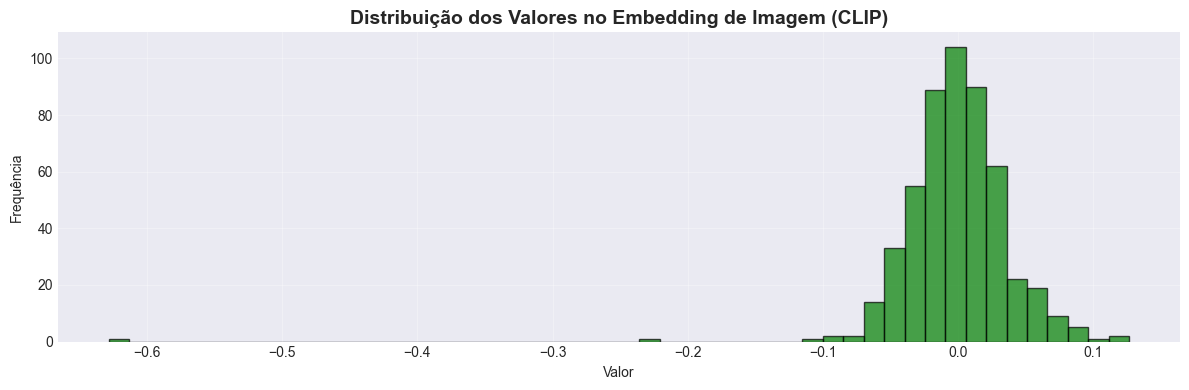

In [51]:
# Visualizar distribuição
plt.figure(figsize=(12, 4))
plt.hist(image_embedding, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Distribuição dos Valores no Embedding de Imagem (CLIP)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Gerando Embeddings para Todas as Imagens

Agora vamos processar todas as imagens do dataset.

In [54]:
image_embeddings = []

for img_data in tqdm(images_data, desc="Processando imagens"):
    # Processar imagem
    inputs = clip_processor(images=img_data['image'], return_tensors="pt").to(device)
    
    # Gerar embedding
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        features = features / features.norm(dim=-1, keepdim=True)
    
    # Converter para numpy e adicionar
    embedding = features.cpu().numpy().flatten()
    image_embeddings.append(embedding)
    img_data['embedding'] = embedding.tolist()

# Converter para array numpy
image_embeddings = np.array(image_embeddings)

print(f"\n✅ Embeddings gerados.")
print(f"Shape da matriz: {image_embeddings.shape}")
print(f"\t- {image_embeddings.shape[0]} imagens")
print(f"\t- {image_embeddings.shape[1]} dimensões por embedding")

Processando imagens: 100%|██████████| 48/48 [00:00<00:00, 64.84it/s]


✅ Embeddings gerados.
Shape da matriz: (48, 512)
	- 48 imagens
	- 512 dimensões por embedding


## 5. Armazenar Imagens no ChromaDB

Vamos criar uma nova coleção no ChromaDB para armazenar os embeddings das imagens.

In [55]:
# Criar coleção para imagens
image_collection_name = "food_images"

# Deletar se já existir
try:
    chroma_client.delete_collection(image_collection_name)
except:
    pass

image_collection = chroma_client.create_collection(
    name=image_collection_name,
    metadata={"description": "Food-101 images with CLIP embeddings", "hnsw:space": "cosine"}
)

print(f"Coleção criada: '{image_collection_name}'")

Coleção criada: 'food_images'


In [56]:
# Preparar dados para inserção
image_ids = [img['id'] for img in images_data]
image_embeddings_list = [img['embedding'] for img in images_data]
image_documents = [f"{img['label_name']} - food image" for img in images_data]
image_metadatas = [
    {
        'label_name': img['label_name'],
        'label_id': img['label_id'],
        'width': img['width'],
        'height': img['height']
    }
    for img in images_data
]

print("Inserindo imagens no ChromaDB...")
image_collection.add(
    ids=image_ids,
    embeddings=image_embeddings_list,
    documents=image_documents,
    metadatas=image_metadatas
)

print(f"\nmagens armazenadas com sucesso:")
print(f"\t- Total de imagens: {image_collection.count()}")

Inserindo imagens no ChromaDB...

magens armazenadas com sucesso:
	- Total de imagens: 48


## 6. Busca Semântica: Texto para Imagem

Agora vamos realizar **busca de imagens usando texto**!

### Magia do CLIP:
Como imagens e textos estão no **mesmo espaço vetorial**, podemos buscar imagens usando descrições textuais!

In [59]:
# Query textual
text_query = "Sobremesa de chocolate"

print("ETAPA 1: QUERY TEXTUAL")
print(f'\t- Query: "{text_query}"')

# Converter texto em embedding usando CLIP
print(f"\nConvertendo texto em embedding...")
text_inputs = clip_processor(text=[text_query], return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

text_query_embedding = text_features.cpu().numpy().flatten()

print("\nETAPA 2: TEXTO COMO VETOR")
print(f"Dimensões: {text_query_embedding.shape}")
print(f"Primeiros 10 valores: {text_query_embedding[:10]}")

ETAPA 1: QUERY TEXTUAL
	- Query: "Sobremesa de chocolate"

Convertendo texto em embedding...

ETAPA 2: TEXTO COMO VETOR
Dimensões: (512,)
Primeiros 10 valores: [-0.00356831 -0.00791058  0.02276908  0.01008079  0.00709001 -0.01415446
 -0.01938617 -0.01470253  0.00416678 -0.01963502]



ETAPA 3: RESULTADOS - IMAGENS ENCONTRADAS

Resultado #1:
	- ID: food_035
	- Categoria: Chocolate Cake
	- Distância Cosine: 0.7217
	- Match Score: 63.9%

Resultado #2:
	- ID: food_030
	- Categoria: Vanilla Ice Cream
	- Distância Cosine: 0.7466
	- Match Score: 62.7%

Resultado #3:
	- ID: food_037
	- Categoria: Cheesecake
	- Distância Cosine: 0.7535
	- Match Score: 62.3%


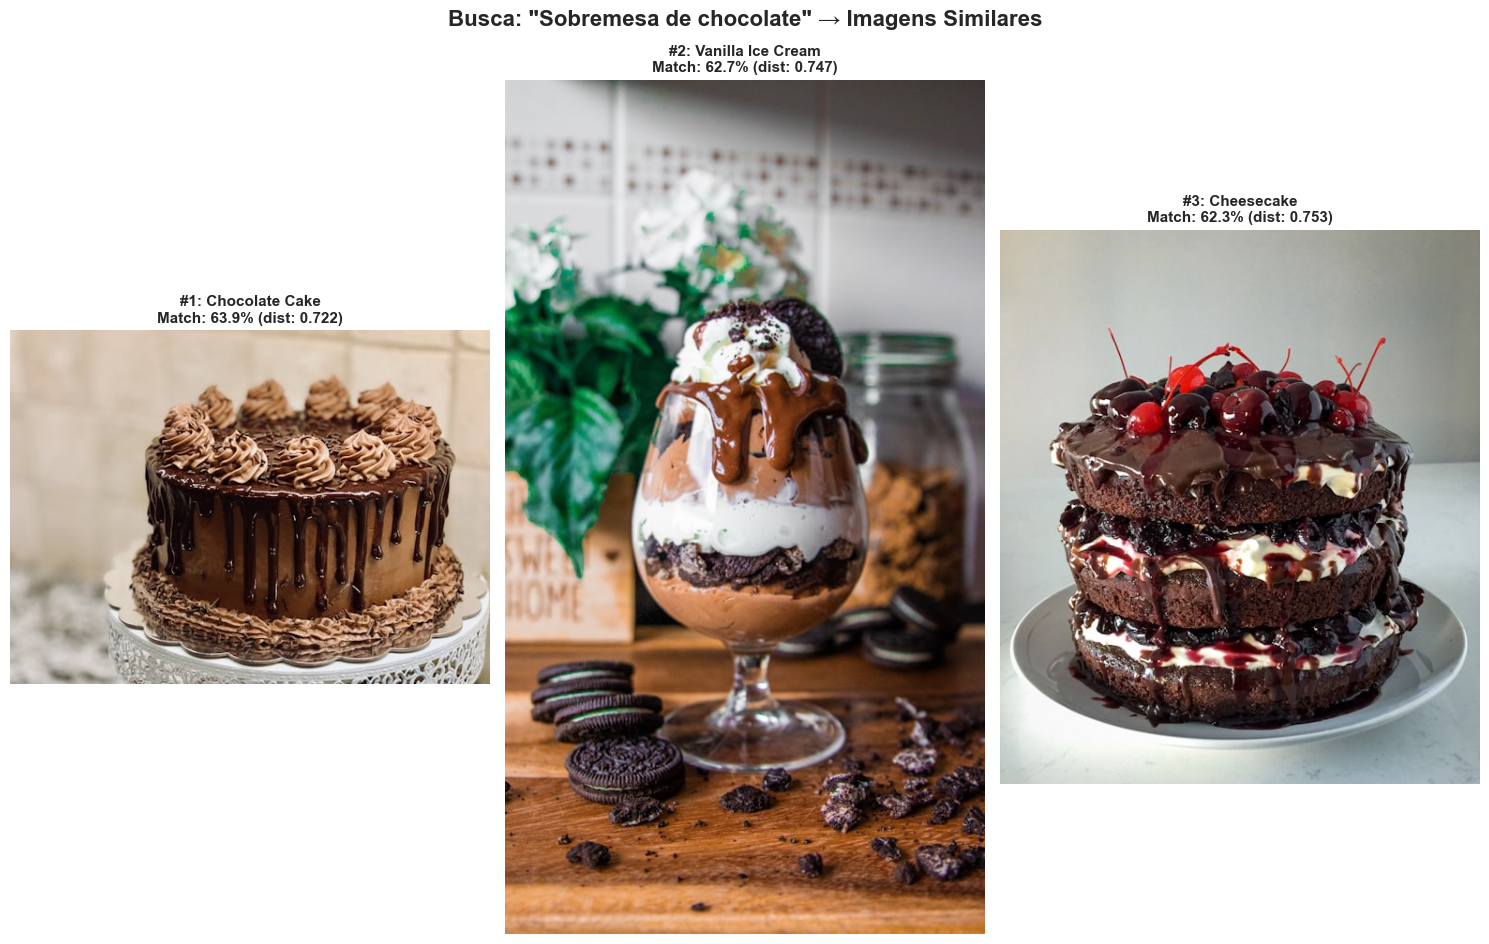

In [62]:
# Buscar no ChromaDB
text_to_image_results = image_collection.query(
    query_embeddings=[text_query_embedding.tolist()],
    n_results=3
)

print("\nETAPA 3: RESULTADOS - IMAGENS ENCONTRADAS")

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (img_id, metadata, distance) in enumerate(zip(
    text_to_image_results['ids'][0],
    text_to_image_results['metadatas'][0],
    text_to_image_results['distances'][0]
)):
    # Encontrar imagem correspondente
    img_data = next(img for img in images_data if img['id'] == img_id)
    
    # Mostrar imagem
    axes[idx].imshow(img_data['image'])
    # Calcular similaridade: quanto MENOR a distância, MAIOR a similaridade
    # Para cosine distance: 0.0 = idêntico, 2.0 = oposto
    similarity_score = (1 - (distance / 2)) * 100  # Converter para porcentagem 0-100%
    axes[idx].set_title(
        f"#{idx+1}: {metadata['label_name']}\n"
        f"Match: {similarity_score:.1f}% (dist: {distance:.3f})",
        fontsize=11, fontweight='bold'
    )
    axes[idx].axis('off')
    
    print(f"\nResultado #{idx+1}:")
    print(f"\t- ID: {img_id}")
    print(f"\t- Categoria: {metadata['label_name']}")
    print(f"\t- Distância Cosine: {distance:.4f}")
    print(f"\t- Match Score: {similarity_score:.1f}%")

plt.suptitle(f'Busca: "{text_query}" → Imagens Similares', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 7. Busca Semântica: Imagem → Imagem

Agora vamos buscar **imagens similares a uma imagem de entrada**!

### Casos de Uso:
"Encontre imagens parecidas com esta", útil para:
- Sistemas de recomendação
- Detecção de duplicatas
- Busca por similaridade visual
- Organização de catálogos

In [63]:
# Selecionar uma imagem como query
query_image_data = images_data[5]  # Imagem de referência
query_image = query_image_data['image']
query_image_embedding = np.array(query_image_data['embedding'])

print("ETAPA 1: IMAGEM DE REFERÊNCIA (Query)")
print(f"\t- ID: {query_image_data['id']}")
print(f"\t- Categoria: {query_image_data['label_name']}")
print(f"\t- Dimensões: {query_image_data['width']}×{query_image_data['height']}")

ETAPA 1: IMAGEM DE REFERÊNCIA (Query)
	- ID: food_005
	- Categoria: Sushi Platter
	- Dimensões: 512×909


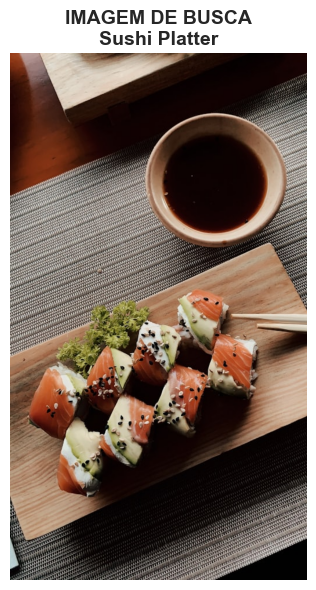

In [64]:
# Mostrar imagem de query
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(query_image)
ax.set_title(f"IMAGEM DE BUSCA\n{query_image_data['label_name']}", 
             fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

In [65]:
# Buscar imagens similares (excluindo a própria imagem)
image_to_image_results = image_collection.query(
    query_embeddings=[query_image_embedding],
    n_results=4  # 4 porque queremos 3 (excluir a própria)
)

# Filtrar resultado que é a própria imagem
filtered_results = {
    'ids': [[]], 
    'metadatas': [[]], 
    'distances': [[]]
}

for img_id, metadata, distance in zip(
    image_to_image_results['ids'][0],
    image_to_image_results['metadatas'][0],
    image_to_image_results['distances'][0]
):
    if img_id != query_image_data['id']:  # Pular a própria imagem
        filtered_results['ids'][0].append(img_id)
        filtered_results['metadatas'][0].append(metadata)
        filtered_results['distances'][0].append(distance)

# Pegar apenas 3 resultados
for key in filtered_results:
    filtered_results[key][0] = filtered_results[key][0][:3]

ETAPA 2: IMAGENS SIMILARES ENCONTRADAS

Resultado #1:
	- ID: food_008
	- Categoria: Nigiri Sushi
	- Distância Cosine: 0.0870
	- Match Score: 95.7%

Resultado #2:
	- ID: food_007
	- Categoria: Sushi Rolls
	- Distância Cosine: 0.0903
	- Match Score: 95.5%

Resultado #3:
	- ID: food_006
	- Categoria: Salmon Sushi
	- Distância Cosine: 0.0953
	- Match Score: 95.2%


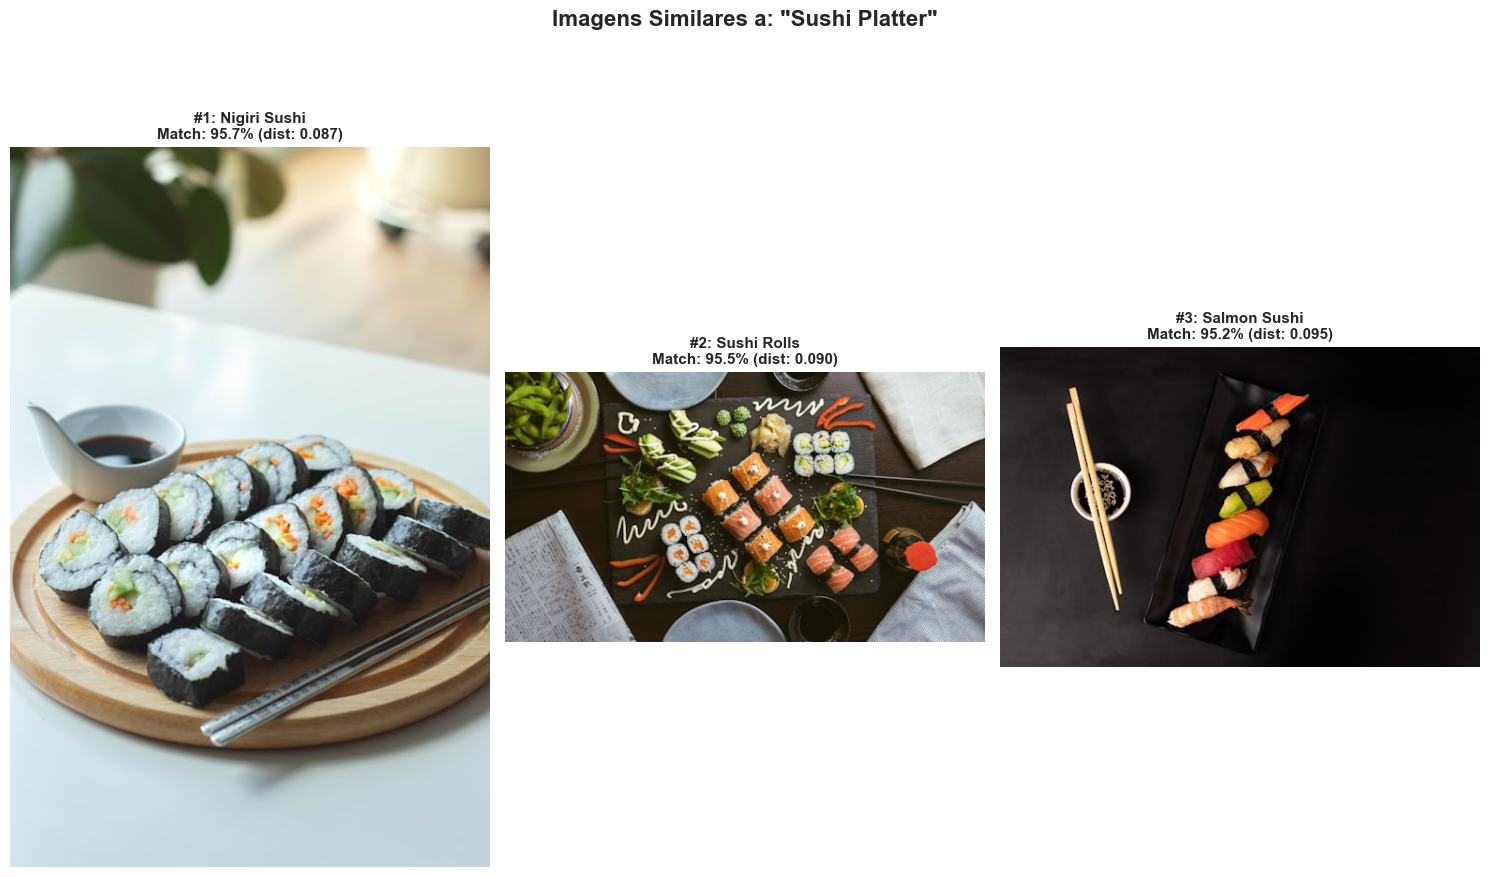

In [66]:
print("ETAPA 2: IMAGENS SIMILARES ENCONTRADAS")

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (img_id, metadata, distance) in enumerate(zip(
    filtered_results['ids'][0],
    filtered_results['metadatas'][0],
    filtered_results['distances'][0]
)):
    # Encontrar imagem
    img_data = next(img for img in images_data if img['id'] == img_id)
    
    # Mostrar
    axes[idx].imshow(img_data['image'])
    similarity_score = (1 - (distance / 2)) * 100  # Converter para porcentagem
    axes[idx].set_title(
        f"#{idx+1}: {metadata['label_name']}\n"
        f"Match: {similarity_score:.1f}% (dist: {distance:.3f})",
        fontsize=11, fontweight='bold'
    )
    axes[idx].axis('off')
    
    print(f"\nResultado #{idx+1}:")
    print(f"\t- ID: {img_id}")
    print(f"\t- Categoria: {metadata['label_name']}")
    print(f"\t- Distância Cosine: {distance:.4f}")
    print(f"\t- Match Score: {similarity_score:.1f}%")

plt.suptitle(f'Imagens Similares a: "{query_image_data["label_name"]}"', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 8. Experimento: Múltiplas Queries Texto para Imagem

Vamos testar diferentes descrições textuais e ver quais imagens o sistema encontra!

TESTANDO MÚLTIPLAS QUERIES TEXTUAIS

Query 1: "salada com vegetais"
   → #1: Quinoa Salad (match: 65.0%)
   → #2: Mixed Greens (match: 65.0%)

Query 2: "macarrão italiano"
   → #1: Spaghetti (match: 63.8%)
   → #2: Penne Pasta (match: 63.1%)

Query 3: "xícara de café"
   → #1: Mocha (match: 63.8%)
   → #2: Americano (match: 63.0%)

Query 4: "frango frito ou carne"
   → #1: Grilled Steak (match: 62.4%)
   → #2: T-Bone Steak (match: 62.2%)


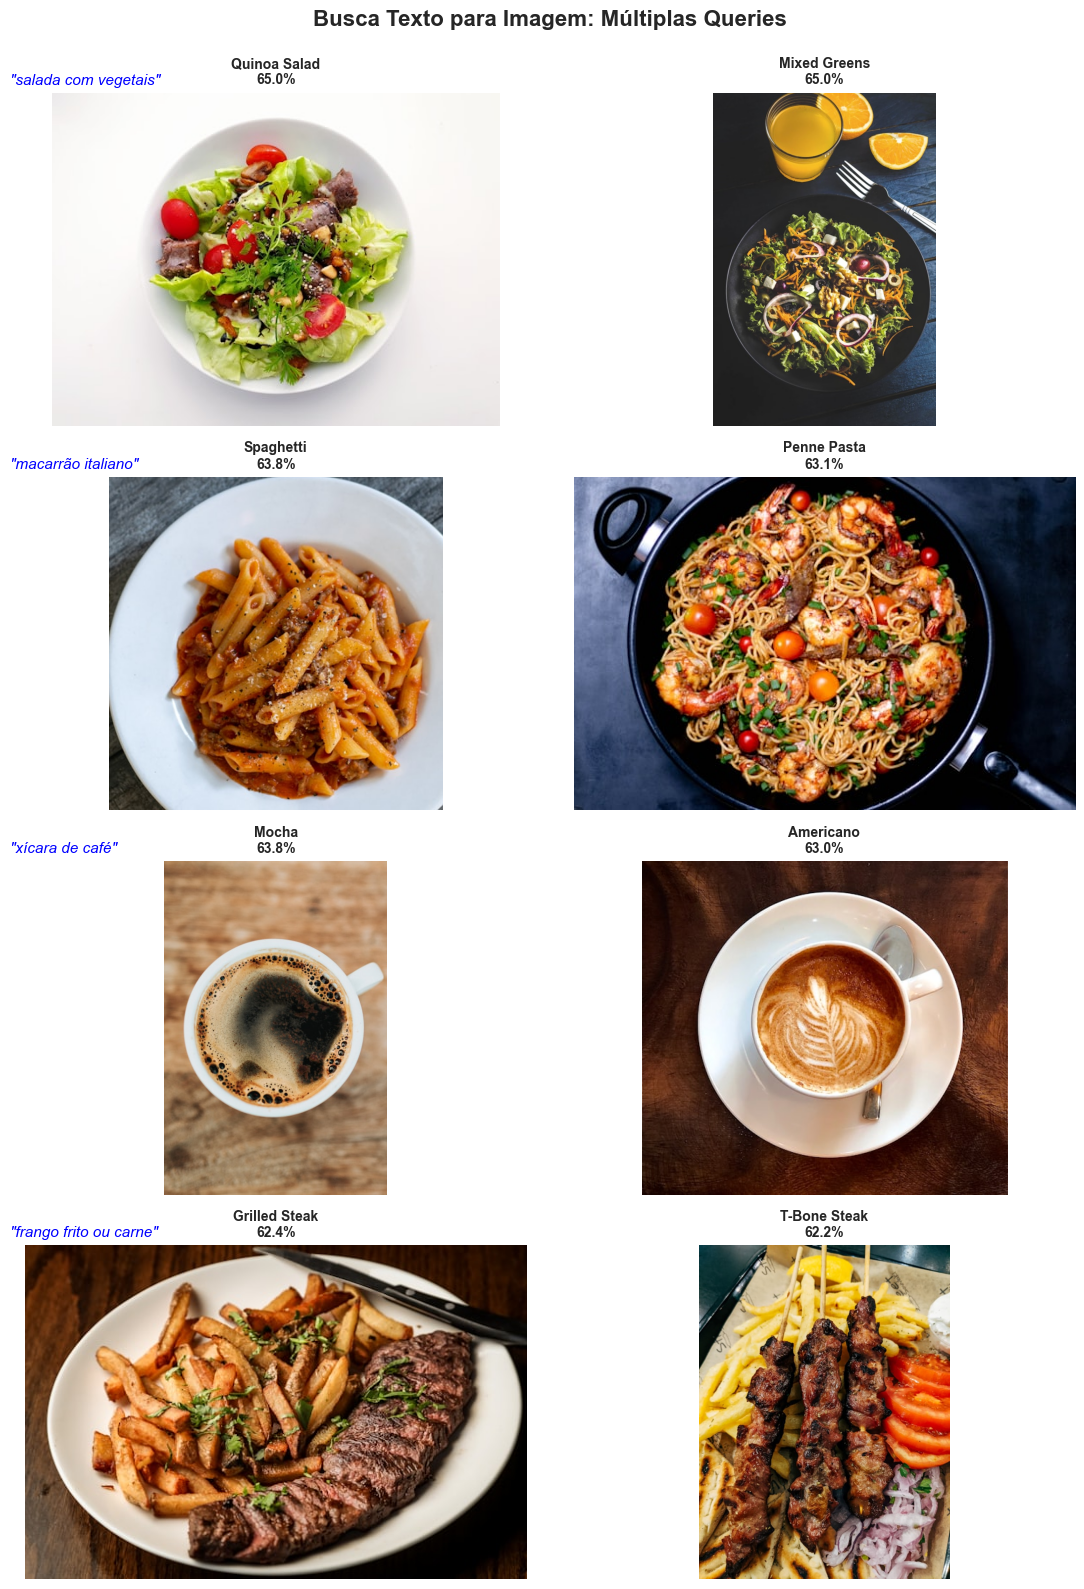

In [68]:
# Diferentes queries textuais
text_queries = [
    "salada com vegetais",
    "macarrão italiano",
    "xícara de café",
    "frango frito ou carne"
]

print("TESTANDO MÚLTIPLAS QUERIES TEXTUAIS")

fig, axes = plt.subplots(len(text_queries), 2, figsize=(12, len(text_queries) * 4))

for row_idx, query in enumerate(text_queries):
    print(f"\nQuery {row_idx + 1}: \"{query}\"")
    
    # Gerar embedding do texto
    text_inputs = clip_processor(text=[query], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_emb = text_features.cpu().numpy().flatten()
    
    # Buscar imagens
    results = image_collection.query(
        query_embeddings=[text_emb.tolist()],
        n_results=2
    )
    
    # Mostrar top 2 resultados
    for col_idx in range(2):
        img_id = results['ids'][0][col_idx]
        metadata = results['metadatas'][0][col_idx]
        distance = results['distances'][0][col_idx]
        similarity_score = (1 - (distance / 2)) * 100
        
        # Encontrar imagem
        img_data = next(img for img in images_data if img['id'] == img_id)
        
        # Plotar
        ax = axes[row_idx, col_idx]
        ax.imshow(img_data['image'])
        ax.set_title(f"{metadata['label_name']}\n{similarity_score:.1f}%", 
                     fontsize=10, fontweight='bold')
        ax.axis('off')
        
        print(f"   → #{col_idx + 1}: {metadata['label_name']} (match: {similarity_score:.1f}%)")

# Título geral
fig.text(0.5, 0.98, 'Busca Texto para Imagem: Múltiplas Queries', 
         ha='center', fontsize=16, fontweight='bold')

# Labels das colunas
for idx, query in enumerate(text_queries):
    fig.text(0.05, 0.95 - (idx * 0.24), f'"{query}"', 
             va='top', fontsize=11, style='italic', color='blue')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()